In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
import matplotlib.pyplot as plt

# Define ML problems

# I. Wrangle Data

**Question:** What issues do we need to address in our `wrangle` function?


In [ ]:
def wrangle(filepath):
  
  df = pd.read_csv(filepath, parse_dates=['Date'], index_col = 'Date')

  df.dropna(subset=['overall'], inplace = True)

  df['great'] = (df['overall'] >= 4).astype(int)

  df.drop(columns='overall', inplace = True)

  categorical_columns = df.select_dtypes('object').columns
  binary_cols = [col for col in categorical_columns if df[col].nunique() < 4 ]

  for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) else 0)

  threshold = 10
  high_card_cols =  [col for col in categorical_columns
                     if df[col].nunique() > threshold ]
  df.drop(high_card_cols, axis=1, inplace=True)

  df.dropna(axis=1, thresh=300, inplace = True)

  return df

In [ ]:
df =wrangle(DATA_PATH + 'burritos/burritos.csv')

In [ ]:
df.head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df['Beef'].value_counts()

x    137
X     42
Name: Beef, dtype: int64

In [ ]:
isinstance(2,int)

True

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cost           414 non-null    float64
 1   Hunger         418 non-null    float64
 2   Tortilla       421 non-null    float64
 3   Temp           401 non-null    float64
 4   Meat           407 non-null    float64
 5   Fillings       418 non-null    float64
 6   Meat:filling   412 non-null    float64
 7   Uniformity     419 non-null    float64
 8   Salsa          396 non-null    float64
 9   Synergy        419 non-null    float64
 10  Wrap           418 non-null    float64
 11  Unreliable     421 non-null    int64  
 12  NonSD          421 non-null    int64  
 13  Beef           421 non-null    int64  
 14  Pico           421 non-null    int64  
 15  Guac           421 non-null    int64  
 16  Cheese         421 non-null    int64  
 17  Fries          421 non-null    int6

# II. Split Data

In [ ]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

In [ ]:
X.shape

(421, 47)

In [ ]:
y.resample('y').sum()

Date
2011-12-31      0
2012-12-31      0
2013-12-31      0
2014-12-31      0
2015-12-31      1
2016-12-31    121
2017-12-31     38
2018-12-31     13
2019-12-31      8
2020-12-31      0
2021-12-31      0
2022-12-31      0
2023-12-31      0
2024-12-31      0
2025-12-31      0
2026-12-31      1
Freq: A-DEC, Name: great, dtype: int64

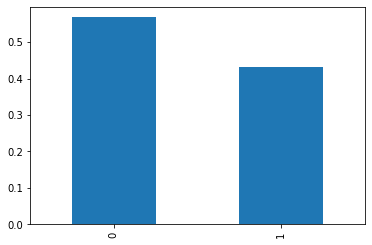

In [ ]:
y.value_counts(normalize=True).plot(kind='bar')

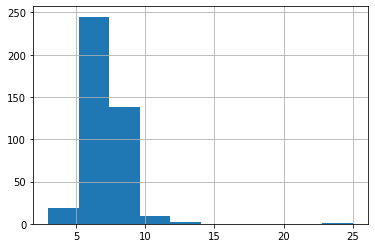

In [ ]:
X['Cost'].hist()

In [ ]:
# Training before 2017
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Validation on 2017
validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

# Testing after 2017

test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]


# III. Establish Baseline

In [ ]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max() )

Baseline accuracy: 0.5906040268456376


# IV. Build Model

what tranformers should we use? 

In [ ]:
# Model 1: Logistic Regression
model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [ ]:
# Model 2: Random Forest
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

**Accuracy**

In [ ]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.912751677852349
Validation Accuracy (LOGR): 0.788235294117647


In [ ]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8235294117647058


**Precision, Recall, F1**

              precision    recall  f1-score   support

           0       0.89      0.70      0.79        47
           1       0.71      0.89      0.79        38

    accuracy                           0.79        85
   macro avg       0.80      0.80      0.79        85
weighted avg       0.81      0.79      0.79        85



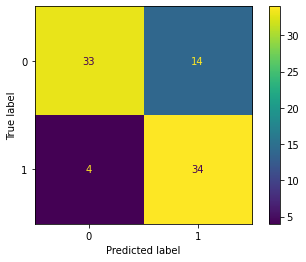

In [ ]:
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        47
           1       0.77      0.87      0.81        38

    accuracy                           0.82        85
   macro avg       0.82      0.83      0.82        85
weighted avg       0.83      0.82      0.82        85



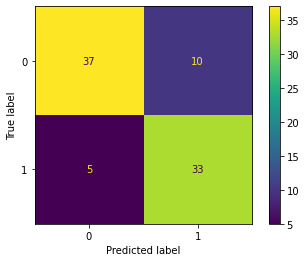

In [ ]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val)

**ROC curve**


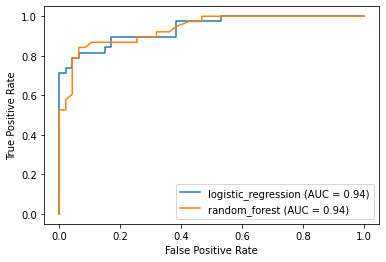

In [ ]:
lr = plot_roc_curve(model_lr,
               X_val,
               y_val,
               name='logistic_regression');

rf = plot_roc_curve(model_rf,
                   X_val,
                   y_val,
                   ax=lr.ax_,
                    name='random_forest');

In [ ]:
roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,-1])

0.9384098544232923

In [ ]:
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1])

0.9364501679731243

In [ ]:
y_pred_proba = model_rf.predict_proba(X_val)[:, -1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [ ]:
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds': thresholds}

pd.DataFrame(data)      

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,1.98
1,0.000000,0.026316,0.98
2,0.000000,0.052632,0.97
3,0.000000,0.157895,0.96
4,0.000000,0.184211,0.94
5,0.000000,0.342105,0.91
6,0.000000,0.394737,0.89
7,0.000000,0.447368,0.85
8,0.000000,0.500000,0.80
9,0.000000,0.526316,0.79
